In [1]:
import pyspark
import pyspark.sql.types as T
import pyspark.sql.functions as F
import requests

sc = pyspark.SparkContext(appName="myAppName")
spark = pyspark.sql.SQLContext(sc)

In [2]:
df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('clean_tweet.csv')

In [3]:
df.show(5)

+---+--------------------+------+
|_c0|                text|target|
+---+--------------------+------+
|  0|awww that bummer ...|     0|
|  1|is upset that he ...|     0|
|  2|dived many times ...|     0|
|  3|my whole body fee...|     0|
|  4|no it not behavin...|     0|
+---+--------------------+------+
only showing top 5 rows



In [4]:
df = df.dropna()
df.count()

1596041

In [5]:
(train_set, val_set) = df.randomSplit([0.9, 0.1], seed = 7)

In [6]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|_c0|                text|target|               words|                  tf|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|  1|is upset that he ...|     0|[is, upset, that,...|(65536,[1444,2071...|(65536,[1444,2071...|  0.0|
|  2|dived many times ...|     0|[dived, many, tim...|(65536,[2548,2888...|(65536,[2548,2888...|  0.0|
|  3|my whole body fee...|     0|[my, whole, body,...|(65536,[158,11650...|(65536,[158,11650...|  0.0|
|  4|no it not behavin...|     0|[no, it, not, beh...|(65536,[1968,4488...|(65536,[1968,4488...|  0.0|
|  5|  not the whole crew|     0|[not, the, whole,...|(65536,[8026,3398...|(65536,[8026,3398...|  0.0|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
roc_auc = evaluator.evaluate(predictions)
print("ROC-AUC: {0:.4f}".format(roc_auc))

ROC-AUC: 0.8582


In [17]:
lr_model_path = "/hdfsData/" + "lr_model"
lrModel.write().overwrite().save(path=lr_model_path)

In [19]:
predictions.show()

+---+--------------------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|_c0|                text|target|               words|                  tf|            features|label|       rawPrediction|         probability|prediction|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|  0|awww that bummer ...|     0|[awww, that, bumm...|(65536,[8436,8847...|(65536,[8436,8847...|  0.0|[3.50500040497862...|[0.97082971151564...|       0.0|
| 14|would ve been the...|     0|[would, ve, been,...|(65536,[14,731,24...|(65536,[14,731,24...|  0.0|[2.93168692076489...|[0.94939078957233...|       0.0|
| 15|wish got to watch...|     0|[wish, got, to, w...|(65536,[8436,2063...|(65536,[8436,2063...|  0.0|[2.71689595828703...|[0.93801630460989...|       0.0|
| 28|ooooh lol that le...|     0|[ooooh, lol, that...|(65536,[80

In [25]:
dataDF_raw = spark.read.json("clean_data.json")

In [20]:
dataDF_raw.printSchema()

root
 |-- body: string (nullable = true)
 |-- closed_at: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- repo_name: string (nullable = true)



In [26]:
dataDF = dataDF_raw.select(dataDF_raw.repo_name, dataDF_raw.body.alias('text'),\
                           dataDF_raw.created_at.cast('timestamp'), dataDF_raw.closed_at.cast('timestamp'))

In [27]:
test_set = dataDF

In [28]:
pipeline2 = Pipeline(stages=[tokenizer, hashtf, idf])
pipelineFit2 = pipeline2.fit(test_set)
test_df = pipelineFit2.transform(test_set)
predictions = lrModel.transform(test_df)

In [29]:
predictions.show()

+---------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|repo_name|                text|         created_at|          closed_at|               words|                  tf|            features|       rawPrediction|         probability|prediction|
+---------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     akka|added actorrefwit...|2019-04-26 06:29:46|               null|[added, actorrefw...|(65536,[1198,4141...|(65536,[1198,4141...|[-0.2441069779058...|[0.43927450016039...|       1.0|
|     akka|evacuated-assembl...|2019-04-25 04:40:04|2019-04-25 04:59:23|[evacuated-assemb...|(65536,[571,2098,...|(65536,[571,2098,...|[2.30899832524215...|[0.90961953956084...|       0.0|
|     akka|`java.time.durati...|2019-04-24 10:46:46|   

In [30]:
preDF = predictions.select(predictions.repo_name, predictions.prediction.cast('int').alias('senti_score'),\
                           predictions.created_at, predictions.closed_at)

In [33]:
preDF.createOrReplaceTempView("data")
preDF_issue_count = spark.sql("""
SELECT repo_name, count(1) issues_count
FROM data
GROUP BY repo_name
ORDER BY issues_count DESC
""")
preDF_issue_count.show()

+-------------+------------+
|    repo_name|issues_count|
+-------------+------------+
|       vscode|       66633|
|           go|       18724|
|      flutter|       16625|
| react-native|       16001|
|        ionic|       15061|
|   tensorflow|       14723|
|         atom|       14429|
|        godot|       13837|
|    cockroach|       13357|
|         rust|       13254|
|   ant-design|       12059|
|       roslyn|       11889|
|      rancher|       11701|
|          sdk|       11630|
|       corefx|       11518|
|       kibana|       11006|
|      element|       10652|
|      angular|       10572|
|         salt|        9902|
|elasticsearch|        9533|
+-------------+------------+
only showing top 20 rows



In [34]:
preDF_issue_count.count()

239

In [32]:
preDF.count()

1064458

In [35]:
import pyspark.sql.functions as F

preDF_mean = preDF.groupBy("repo_name")\
.agg(F.bround(F.mean("senti_score"), 3).alias("mean"), F.bround(F.stddev("senti_score"), 3).alias("stand_dev"))\
.orderBy("mean", ascending=False)
preDF_mean.show()

+--------------------+-----+---------+
|           repo_name| mean|stand_dev|
+--------------------+-----+---------+
|       homebrew-cask|  1.0|      0.0|
|                taro|0.887|    0.316|
|          youtube-dl|0.856|    0.352|
|           spacemacs|0.756|    0.429|
|      ant-design-pro|0.753|    0.431|
|           kubespray|0.744|    0.437|
|                 egg|0.743|    0.437|
|        cert-manager| 0.74|    0.439|
|               gitea| 0.74|    0.439|
|            selenium| 0.73|    0.444|
|             typeorm|0.728|    0.445|
|              rclone|0.728|    0.445|
|                tidb|0.725|    0.447|
|            frontend|0.725|     0.45|
|        Font-Awesome| 0.72|    0.449|
|   mattermost-server|0.714|    0.452|
|               servo|0.714|    0.452|
|     DefinitelyTyped|0.714|    0.452|
|office-ui-fabric-...|0.712|    0.453|
|               sympy|0.706|    0.456|
+--------------------+-----+---------+
only showing top 20 rows



In [36]:
preDF.agg(F.bround(F.mean("senti_score"), 3).alias("mean"), F.bround(F.stddev("senti_score"), 3).alias("stand_dev"))\
.show()

+-----+---------+
| mean|stand_dev|
+-----+---------+
|0.583|    0.493|
+-----+---------+



In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
%matplotlib inline 

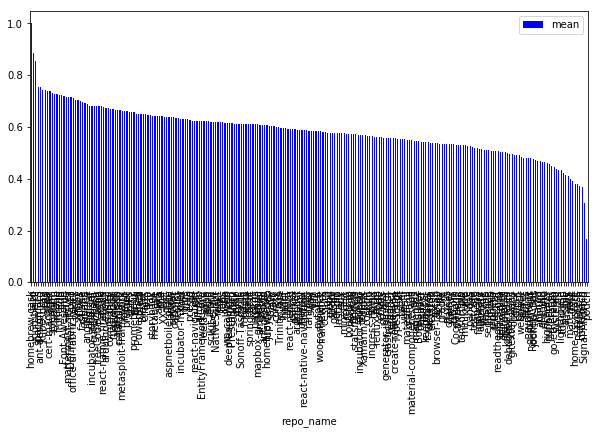

In [40]:
preDF_mean.toPandas().plot(kind="bar", x="repo_name", y="mean", figsize=(10,5), color="blue")

In [42]:
preDF_senti = preDF.select('repo_name', "senti_score")

In [44]:
from pyspark.sql.functions import col,when,count

preDF_senti_pd = preDF_senti.groupBy("repo_name").agg(count(when((col("senti_score")>=0.5),True)).alias('positive'),\
                                      count(when(col("senti_score")<0.5,True)).alias('negative')).toPandas()

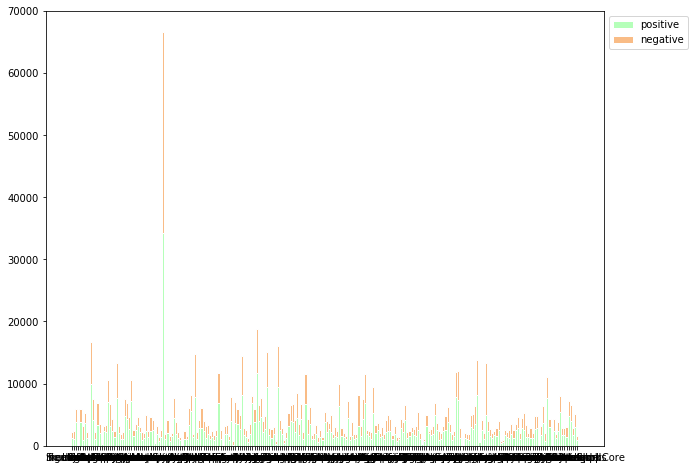

In [49]:
from matplotlib import rc

r = range(239)
barWidth = 1
plt.figure(figsize=(10,8))
plt.bar(r, preDF_senti_pd['positive'], color='#b5ffb9', edgecolor='white', width=barWidth, label="positive")
plt.bar(r, preDF_senti_pd['negative'], bottom=preDF_senti_pd['positive'], \
        color='#f9bc86', edgecolor='white', width=barWidth, label="negative")
plt.xticks(r, preDF_senti_pd['repo_name'])
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.show()

In [38]:
preDF_mean_pd = preDF_mean.select("repo_name", preDF_mean['mean'].alias('senti_mean')).toPandas()

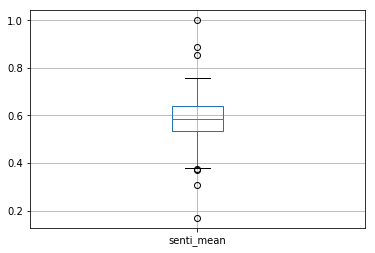

In [39]:
preDF_mean_pd.boxplot()

In [50]:
from pyspark.sql.functions import dayofweek, hour

In [51]:
preDF_dayofweek = preDF.select(dayofweek('created_at').alias("dayofweek"), "senti_score")
preDF_dayofweek_r = preDF_dayofweek.orderBy("dayofweek").groupBy("dayofweek")\
.agg(F.count("senti_score").alias("issues_num"), F.bround(F.count("senti_score")/preDF.count()*100, 3).alias("percent"), \
     F.bround(F.mean("senti_score"), 3).alias("mean"), F.bround(F.stddev("senti_score"), 3).alias("stand_dev"))
preDF_dayofweek_r.show()

+---------+----------+-------+-----+---------+
|dayofweek|issues_num|percent| mean|stand_dev|
+---------+----------+-------+-----+---------+
|        1|     82433|  7.744|0.579|    0.494|
|        2|    171341| 16.097|0.585|    0.493|
|        3|    187597| 17.624|0.583|    0.493|
|        4|    191162| 17.959|0.582|    0.493|
|        5|    188163| 17.677|0.583|    0.493|
|        6|    164940| 15.495|0.584|    0.493|
|        7|     78822|  7.405|0.578|    0.494|
+---------+----------+-------+-----+---------+



In [53]:
from pyspark.sql.functions import ceil, floor

preDF_timeofday = preDF.select((when(floor(hour('created_at')/6) == 0, 'night')\
                                  .when(floor(hour('created_at')/6) == 1, 'morning')\
                                             .when(floor(hour('created_at')/6) == 2, 'afternoon')\
                                                        .otherwise('evening')).alias("timeofday"), "senti_score")
preDF_timeofday_r = preDF_timeofday.orderBy('senti_score').groupBy("timeofday")\
.agg(F.count("senti_score").alias("issues_num"), F.bround(F.count("senti_score")/preDF.count()*100, 3).alias("percent"), \
     F.bround(F.mean("senti_score"), 3).alias("mean"), F.bround(F.stddev("senti_score"), 3).alias("stand_dev"))
preDF_timeofday_r.show()

# night, morning, afternoon, evening

+---------+----------+-------+-----+---------+
|timeofday|issues_num|percent| mean|stand_dev|
+---------+----------+-------+-----+---------+
|afternoon|    307904| 28.926|0.584|    0.493|
|    night|    242400| 22.772| 0.58|    0.493|
|  morning|    321401| 30.194|0.578|    0.494|
|  evening|    192753| 18.108| 0.59|    0.492|
+---------+----------+-------+-----+---------+



In [54]:
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums

In [56]:
preDF_dayofweek_pd = preDF_dayofweek.toPandas()
monday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 1]
tuesday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 2]
wednesday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 3]
thursday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 4]
friday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 5]
saturday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 6]
sunday = preDF_dayofweek_pd.loc[preDF_dayofweek_pd['dayofweek'] == 7]

In [57]:
df_list = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]
for i in range(len(df_list)):
    for j in range(i+1, len(df_list)):
        s, pvalue = mannwhitneyu(df_list[i]["senti_score"], df_list[j]["senti_score"])
        if pvalue <= 0.05:
            print(i, j, pvalue)

0 1 0.006469964257925548
0 2 0.038343616748278915
0 4 0.038714727570423275
0 5 0.010956286068048602
1 3 0.03595883719573502
1 6 0.0010186558317693802
2 6 0.008461344699585456
3 6 0.04261223136669141
4 6 0.008556399766455083
5 6 0.00192231881977555


In [58]:
preDF_timeofday_pd = preDF_timeofday.toPandas()
morning = preDF_timeofday_pd.loc[preDF_timeofday_pd['timeofday'] == 'morning']
afternoon = preDF_timeofday_pd.loc[preDF_timeofday_pd['timeofday'] == 'afternoon']
evening = preDF_timeofday_pd.loc[preDF_timeofday_pd['timeofday'] == 'evening']
night = preDF_timeofday_pd.loc[preDF_timeofday_pd['timeofday'] == 'night']

In [59]:
df_list = [morning, afternoon, evening, night]
for i in range(len(df_list)):
    for j in range(i+1, len(df_list)):
        s, pvalue = mannwhitneyu(df_list[i]["senti_score"], df_list[j]["senti_score"])
        if pvalue <= 0.05:
            print(i, j, pvalue)

0 1 2.0628233399508542e-06
0 2 1.1947422759989431e-17
0 3 0.047957249392960054
1 2 5.181904643792143e-06
1 3 0.004303632335915692
2 3 3.2073761579846e-11


In [60]:
from pyspark.sql.functions import datediff

In [61]:
preDF_datediff_0 = preDF.select(datediff("closed_at", 'created_at').alias("time_span"), "senti_score")\
.where(preDF.closed_at.isNotNull()).orderBy("time_span", ascending=False).groupBy("time_span")\
.agg(F.bround(F.mean("senti_score"), 3).alias("senti_mean"))

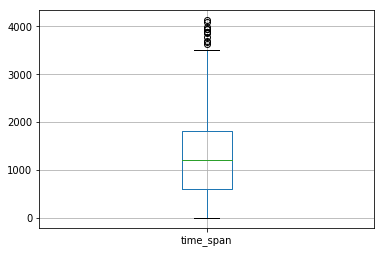

In [62]:
preDF_datediff_0.toPandas().boxplot(column='time_span')

In [64]:
from scipy.stats import spearmanr

In [65]:
preDF_datediff_pd_0 = preDF_datediff_0.toPandas()
spearmanr(preDF_datediff_pd_0['time_span'], preDF_datediff_pd_0['senti_mean'])

SpearmanrResult(correlation=0.10962818154670297, pvalue=6.466715789175388e-08)

In [68]:
preDF_datediff = preDF.select(ceil(datediff("closed_at", 'created_at')/100).alias("bin"), "senti_score")\
.where(preDF.closed_at.isNotNull()).orderBy("bin", ascending=False).groupBy("bin")\
.agg(F.bround(F.mean("senti_score"), 3).alias("senti_mean"))
preDF_datediff.show()

+---+----------+
|bin|senti_mean|
+---+----------+
| 42|       0.0|
| 41|       1.0|
| 40|     0.333|
| 39|       1.0|
| 38|       1.0|
| 37|     0.667|
| 36|       1.0|
| 35|       0.8|
| 34|       1.0|
| 33|     0.333|
| 32|       1.0|
| 31|       1.0|
| 30|       1.0|
| 29|       0.4|
| 28|     0.667|
| 27|     0.438|
| 26|     0.667|
| 25|     0.718|
| 24|     0.611|
| 23|       0.6|
+---+----------+
only showing top 20 rows



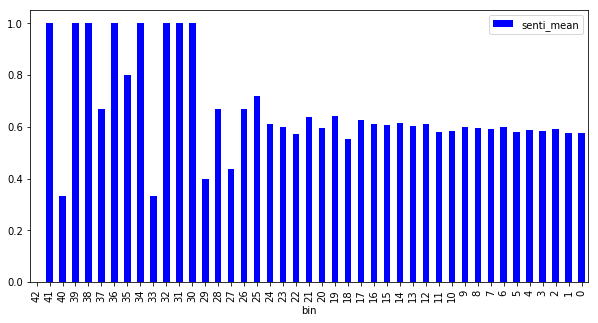

In [69]:
preDF_datediff.toPandas().plot(kind="bar", x="bin", y="senti_mean", figsize=(10,5), color="blue")